In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F # Import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Step 2: Define Dataset class (matches by filename and uses only E_eff)
class MicrostructureDataset(Dataset):
    def __init__(self, image_dir, metadata_df):
        self.image_dir = image_dir
        self.df = metadata_df
        self.available_files = set(os.listdir(image_dir))
        # Filter only matching entries (ensure the image exists)
        self.df = self.df[self.df['filename'].isin(self.available_files)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']
        e_eff = torch.tensor(row['E_eff'], dtype=torch.float32)

        img_path = os.path.join(self.image_dir, filename)
        img = np.load(img_path).astype(np.float32)
        img = torch.tensor(img).unsqueeze(0)  # shape: [1, 65, 65]

        return img, e_eff

In [ ]:
# Step 3: Load CSV with metadata and prepare DataFrames
csv_path = '/content/drive/MyDrive/Artificial intelligence in computational mechanics/Assignment/Datasets/excel/material_property.csv'
metadata_df = pd.read_csv(csv_path)[['filename', 'E_eff']]

In [ ]:
# Step 4: Define image directories (adjust these paths as needed)
train_dir = '/content/drive/MyDrive/Artificial intelligence in computational mechanics/Assignment/Datasets/Train'
val_dir = '/content/drive/MyDrive/Artificial intelligence in computational mechanics/Assignment/Datasets/Validation'
test_dir = '/content/drive/MyDrive/Artificial intelligence in computational mechanics/Assignment/Datasets/Test'

In [ ]:
# Added
train_dataset = MicrostructureDataset(train_dir, metadata_df)
val_dataset = MicrostructureDataset(val_dir, metadata_df)
test_dataset = MicrostructureDataset(test_dir, metadata_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Define the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


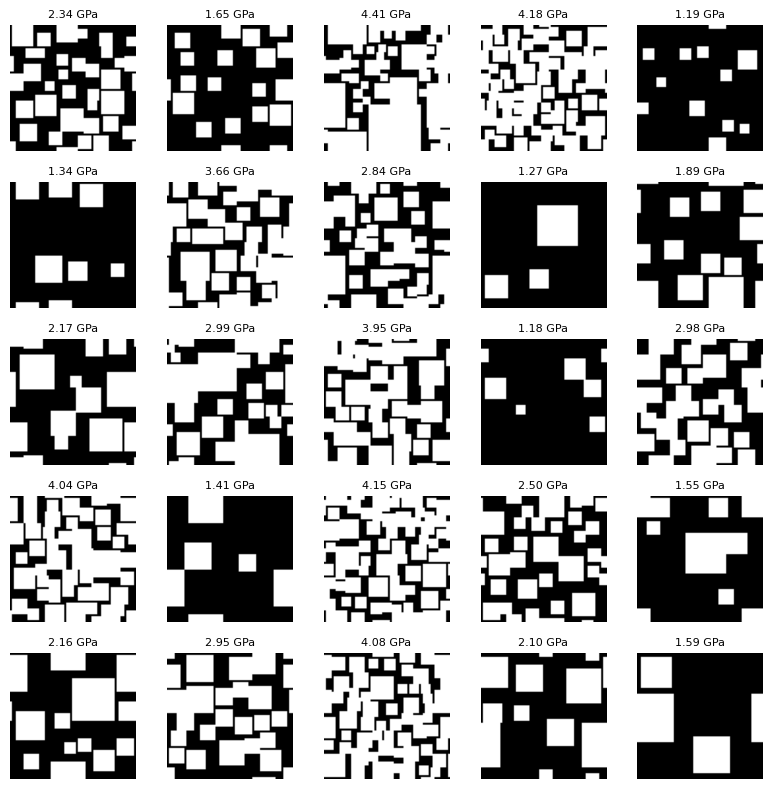

In [ ]:
# Step 5: Visual check
sample_df = metadata_df[metadata_df['filename'].isin(os.listdir(train_dir))].sample(25).reset_index(drop=True)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
axes = axes.flatten()
for i in range(25):
    row = sample_df.iloc[i]
    img_path = os.path.join(train_dir, row['filename'])
    image = np.load(img_path).astype(np.float32)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0–1
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"{row['E_eff']*1e-9:.2f} GPa", fontsize=8)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class UltraWideCNN(nn.Module):
    def __init__(self):
        super(UltraWideCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout rate of 50%

        self.fc1 = nn.Linear(1024 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 65x65 → 32x32
        x = self.pool(F.relu(self.conv2(x)))   # 32x32 → 16x16
        x = self.pool(F.relu(self.conv3(x)))   # 16x16 → 8x8
        x = self.pool(F.relu(self.conv4(x)))   # 8x8 → 4x4

        x = self.dropout(x)                    # Dropout after conv layers
        x = x.view(-1, 1024 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                    # Dropout after FC layer
        x = self.fc2(x)
        return x

In [ ]:
# Count parameters
# Create an instance of the model and move it to the defined device
model = UltraWideCNN().to(device) # Add this line

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {pytorch_total_params}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

Total trainable parameters: 22975489


In [ ]:
# Step 5: Training Loop
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Move inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model state dict to the correct path
        torch.save(model.state_dict(), '/content/drive/MyDrive/Artificial intelligence in computational mechanics/Assignment/best_model.pth') # Corrected path

    print(f"Epoch {epoch+1}/30, Train Loss: {train_loss*100:.2f}%, Validation Loss: {val_loss*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 837561613624646041600.00%, Validation Loss: 846893077183612059648.00%
Epoch 2/30, Train Loss: 837556071398847283200.00%, Validation Loss: 846871984885552381952.00%
Epoch 3/30, Train Loss: 837480026425891225600.00%, Validation Loss: 846661611660771328000.00%
Epoch 4/30, Train Loss: 836951834783802982400.00%, Validation Loss: 845502964632614862848.00%
Epoch 5/30, Train Loss: 834576456735103385600.00%, Validation Loss: 841035483962216808448.00%
Epoch 6/30, Train Loss: 826922388644954112000.00%, Validation Loss: 827505718504526184448.00%
Epoch 7/30, Train Loss: 805772832372110131200.00%, Validation Loss: 793392582269442457600.00%
Epoch 8/30, Train Loss: 755285691094112665600.00%, Validation Loss: 719417843106936782848.00%
Epoch 9/30, Train Loss: 657912553073226547200.00%, Validation Loss: 582111307485308518400.00%
Epoch 10/30, Train Loss: 493318648256423526400.00%, Validation Loss: 380140239035336884224.00%
Epoch 11/30, Train Loss: 338256452690483609600.00%, Validat

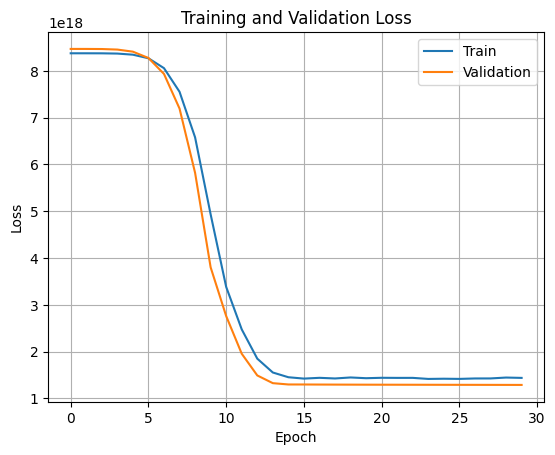

In [ ]:
# Step 6: Plot Loss Curve
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 7: Load Best Model and Evaluate
model.load_state_dict(torch.load('/content/drive/MyDrive/Artificial intelligence in computational mechanics/Assignment/best_model.pth'))
model.eval()

with torch.no_grad():
    count_within_30 = 0
    total = 0
    for x, y_true in test_loader:
        # Move inputs and targets to the device
        x = x.to(device)
        y_true = y_true.to(device)

        y_pred = model(x)
        for i in range(len(y_true)):
            pred = y_pred[i].item()
            true = y_true[i].item()
            relative_error = abs(pred - true) / true
            if relative_error < 0.30:
                count_within_30 += 1
            total += 1
    print(f"Percentage of test predictions within 30% error: {100 * count_within_30 / total:.2f}%")

Percentage of test predictions within 30% error: 77.27%


In [ ]:
# Step 8: Show 10 Sample Predictions
with torch.no_grad():
    for x, y_true in test_loader:
        # Move inputs and targets to the device
        x = x.to(device) # Add this line
        y_true = y_true.to(device) # This line is already there and correct

        y_pred = model(x)
        for i in range(min(len(y_true), 10)):
            print(f"Predicted: {y_pred[i].item():.2f}, True: {y_true[i].item():.2f}")
        break


Predicted: 3109704192.00, True: 3764641280.00
Predicted: 3153181184.00, True: 3774566144.00
Predicted: 2973323520.00, True: 3687965952.00
Predicted: 1836219904.00, True: 1614258560.00
Predicted: 3092171264.00, True: 5045902848.00
Predicted: 2447994880.00, True: 1960251904.00
Predicted: 3213453568.00, True: 3913257472.00
Predicted: 3126854144.00, True: 3667392768.00
Predicted: 2769170944.00, True: 2430564096.00
Predicted: 2976691456.00, True: 4104177152.00


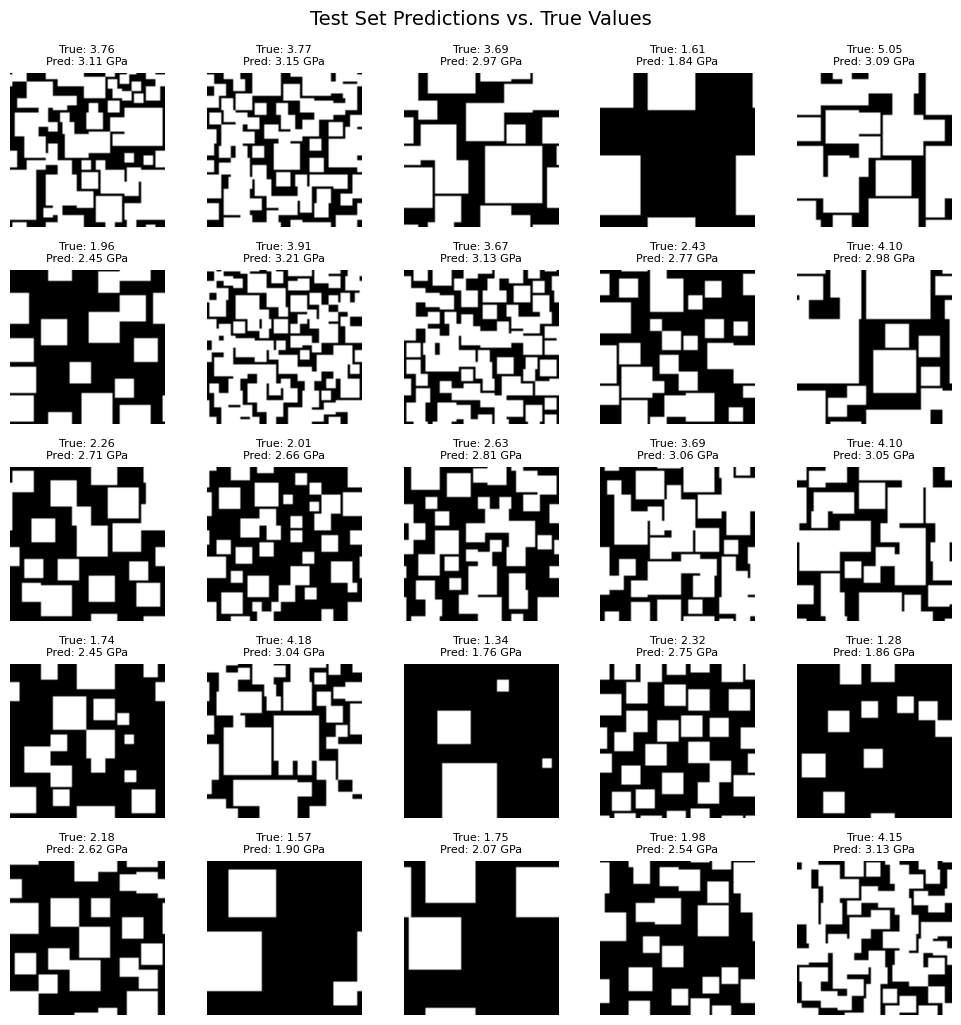

In [ ]:

model.eval() # Ensure model is in evaluation mode

with torch.no_grad():
    # Get a batch from the test loader
    # We'll take the first batch for visualization
    x, y_true = next(iter(test_loader))

    # Move inputs to the device and get predictions
    x_device = x.to(device)
    y_pred = model(x_device)

    # Move data back to CPU for plotting
    x_cpu = x.cpu().squeeze(1).numpy() # Remove channel dimension, convert to numpy
    y_true_cpu = y_true.cpu().numpy()
    y_pred_cpu = y_pred.cpu().squeeze(1).numpy() # Remove prediction dimension

    # Select how many samples to display (e.g., 25 samples from the batch)
    num_samples_to_show = min(len(x_cpu), 25)

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_samples_to_show):
        image = x_cpu[i]
        true_val = y_true_cpu[i]
        pred_val = y_pred_cpu[i]

        # Normalize image for display if needed (assuming image values might not be 0-1)
        if image.max() > image.min():
             image = (image - image.min()) / (image.max() - image.min())

        axes[i].imshow(image, cmap='gray')
        # Display true and predicted values, converting to GPa for readability
        axes[i].set_title(f"True: {true_val*1e-9:.2f}\nPred: {pred_val*1e-9:.2f} GPa", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Test Set Predictions vs. True Values', y=1.02, fontsize=14) # Add a main title
    plt.show()